In [4]:
import pickle
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output
from ipywidgets import interact
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# !ffmpeg -y -i exile.mp4 -ac 1 -ar 16000 audio_5.wav
!ffmpeg -y -i noise_samples/poezd.mp3 -ac 1 -ar 16000 noise_1.wav

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [20]:
# считывание аудио файла
fs, data = wavfile.read('audio_2.wav')
data = data / (2**16-1)
data[0] = 1
# добавление шума
#noise = np.random.normal(scale=0.25*data.std(), size=data.shape)
_, noise = wavfile.read('noise.wav')
noise = noise / (2**16-1) 
noise = np.tile(noise, 1+data.size//noise.size)[:data.size].copy()
noise = (0.1*data.max()/noise.max())*noise
data_noised = data+noise#np.clip(data + noise, -1, 1)

In [21]:
print('Original')
display(Audio(data[fs*10:fs*25], rate=fs))
print('Noised')
display(Audio(data_noised[fs*10:fs*25], rate=fs))

Original


Noised


In [22]:
_, _, Zxx = signal.stft(data_noised, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx, fs)
print('Reconstructed Noised')
display(Audio(xrec[fs*10:fs*25], rate=fs))
_, _, Zxx0 = signal.stft(noise, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx0, fs)
print('Noise')
display(Audio(xrec[fs*10:fs*25], rate=fs))

Reconstructed Noised


Noise


In [23]:
# https://github.com/digantamisra98/Mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        return x*self.tanh(self.softplus(x))

class DenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(512, 800, kernel_size=3, stride=2, padding=1),
            Mish(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(800, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(512, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(256, 2, kernel_size=3, stride=2, padding=1),
        )
            

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = DenoisingAE()
net.to(device)
print(Zxx.shape[0])
net(torch.rand(1, 2, Zxx.shape[0], device=device)).detach().cpu().numpy().shape

257


(1, 2, 257)

In [24]:
criterion = nn.MSELoss()#nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)#, weight_decay=1e-6)

In [25]:
batch_size = 128

X = np.concatenate([np.real(Zxx).T[:,:,None],
                    np.imag(Zxx).T[:,:,None]], axis=-1)
y = np.concatenate([np.real(Zxx0).T[:,:,None],
                    np.imag(Zxx0).T[:,:,None]], axis=-1)

normalization = X.reshape(-1, 2).std()
X /= normalization
y /= normalization
tensor_x = torch.Tensor(np.transpose(X, [0, 2, 1])) # channels first
tensor_y = torch.Tensor(np.transpose(y, [0, 2, 1])) # channels first

train_dataset = TensorDataset(tensor_x[:tensor_x.shape[0]*9//10],
                              tensor_y[:tensor_x.shape[0]*9//10]) # create your datset
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True) # create your dataloader
test_dataset = TensorDataset(tensor_x[tensor_x.shape[0]*9//10:],
                              tensor_y[tensor_x.shape[0]*9//10:]) # create your datset
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size, shuffle=True) # create your dataloader

In [26]:
def eval_dataset(dataloader):
    net.eval()
    target = []
    pred = []
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        preds = net(inputs).detach().cpu().numpy()
        target.append(inputs.detach().cpu().numpy().reshape(inputs.shape[0], -1))
        pred.append(preds.reshape(inputs.shape[0], -1))
    net.train()
    target = np.concatenate(target)
    pred = np.concatenate(pred)
    return r2_score(target, pred)

eval_dataset(train_dataloader)

-4.2971906101475685

105it [00:20,  5.16it/s]0:00<?, ?it/s]


[1,   105] loss: 0.02397


  7%|▋         | 1/15 [00:27<06:28, 27.75s/it]

R2 score on train: 0.07466875850647556
R2 score on val: 0.03316739963746295


105it [00:24,  4.36it/s]


[2,   105] loss: 0.01638


 13%|█▎        | 2/15 [00:59<06:32, 30.18s/it]

R2 score on train: 0.08637725083244406
R2 score on val: 0.08806213541015044


105it [00:24,  4.34it/s]


[3,   105] loss: 0.01497


 20%|██        | 3/15 [01:31<06:11, 30.95s/it]

R2 score on train: 0.09584710920973087
R2 score on val: 0.11001336198567606


105it [00:23,  4.40it/s]


[4,   105] loss: 0.01426


 27%|██▋       | 4/15 [02:03<05:43, 31.19s/it]

R2 score on train: 0.09049141076311126
R2 score on val: 0.08204116546437318


105it [00:24,  4.36it/s]


[5,   105] loss: 0.01385


 33%|███▎      | 5/15 [02:34<05:14, 31.46s/it]

R2 score on train: 0.0876645221725722
R2 score on val: 0.09715937658277869


105it [00:24,  4.26it/s]


[6,   105] loss: 0.01349


 40%|████      | 6/15 [03:07<04:47, 31.96s/it]

R2 score on train: 0.09223519020457742
R2 score on val: 0.10927282162784314


105it [00:24,  4.29it/s]


[7,   105] loss: 0.01318


 47%|████▋     | 7/15 [03:40<04:16, 32.09s/it]

R2 score on train: 0.08631972590682482
R2 score on val: 0.09618973490737151


105it [00:24,  4.31it/s]


[8,   105] loss: 0.01302


 53%|█████▎    | 8/15 [04:12<03:44, 32.09s/it]

R2 score on train: 0.08774839760082385
R2 score on val: 0.09508647612043533


105it [00:24,  4.31it/s]


[9,   105] loss: 0.01287


 60%|██████    | 9/15 [04:44<03:12, 32.11s/it]

R2 score on train: 0.08629407789051179
R2 score on val: 0.08171179681082565


105it [00:24,  4.20it/s]


[10,   105] loss: 0.01270


 67%|██████▋   | 10/15 [05:17<02:42, 32.42s/it]

R2 score on train: 0.09377454949623347
R2 score on val: 0.10668023846317191


105it [00:24,  4.21it/s]


[11,   105] loss: 0.01258


 73%|███████▎  | 11/15 [05:50<02:10, 32.62s/it]

R2 score on train: 0.09550235118302655
R2 score on val: 0.10962153237772906


105it [00:25,  4.15it/s]


[12,   105] loss: 0.01249


 80%|████████  | 12/15 [06:24<01:38, 32.90s/it]

R2 score on train: 0.08870520970264385
R2 score on val: 0.09421245867363531


105it [00:25,  4.13it/s]


[13,   105] loss: 0.01239


 87%|████████▋ | 13/15 [06:58<01:06, 33.17s/it]

R2 score on train: 0.08535493912698935
R2 score on val: 0.07870907880866869


105it [00:25,  4.11it/s]


[14,   105] loss: 0.01229


 93%|█████████▎| 14/15 [07:31<00:33, 33.35s/it]

R2 score on train: 0.08888537137075324
R2 score on val: 0.10932035185075945


105it [00:25,  4.11it/s]


[15,   105] loss: 0.01219


100%|██████████| 15/15 [08:05<00:00, 32.39s/it]

R2 score on train: 0.08954365097954124
R2 score on val: 0.10136234748686411
Finished Training


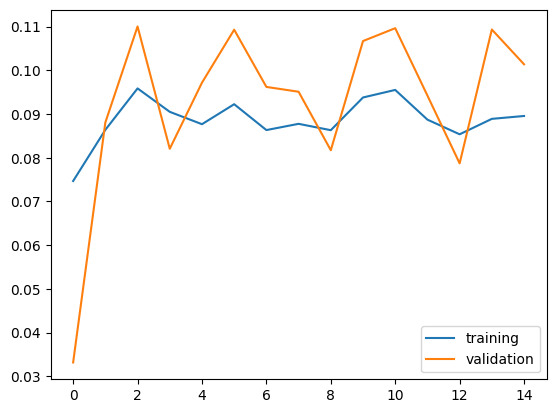

In [27]:
scores = []
scores_val = []
net.train()
for epoch in tqdm(range(15)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.5f}')
    scores.append(eval_dataset(train_dataloader))
    scores_val.append(eval_dataset(test_dataloader))
    print('R2 score on train:', scores[-1])
    print('R2 score on val:', scores_val[-1])
print('Finished Training')
plt.plot(scores, label='training')
plt.plot(scores_val, label='validation')
plt.legend()

In [29]:
net.eval()
pred = []
batch_size = 128
for i in tqdm(range(tensor_x.shape[0]//batch_size+1)):
    preds = net(tensor_x[i*batch_size:(i+1)*batch_size].to(device))
    pred.append(np.transpose(preds.detach().cpu().numpy(),
                             [0, 2, 1])*normalization)
pred = np.concatenate(pred, axis=0) 
_, xrec = signal.istft((pred[:,:,0]+pred[:,:,1]*1j).T, fs)
xrec = data_noised - xrec[:data.size]
print(r2_score(data, data_noised))
print(r2_score(data, xrec[:data.size]))
print('Original')
display(Audio(data[fs*10:fs*25], rate=fs))
print('Noised')
display(Audio(data_noised[fs*10:fs*25], rate=fs))
print('Denoised')
display(Audio(xrec[fs*10:fs*25], rate=fs))

100%|██████████| 116/116 [00:06<00:00, 18.23it/s]


0.9802594480130072
0.9885756083624473
Original


Noised


Denoised
